In [8]:
%load_ext autoreload
%autoreload 2

In [9]:
from py_extrema.extrema import ExtremaFinder, CriticalPoints
from FyeldGenerator import generate_field
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import ipyvolume.pylab as p3

from scipy.interpolate import interp1d
from collections import defaultdict
from tqdm import tqdm
import pandas as pd


from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (12, 9)

In [10]:
# Helper that generates power-law power spectrum
def Pkgen(n):
    def Pk(k):
        return np.power(k, -n)

    return Pk

# Draw samples from a normal distribution
def distrib(shape):
    a = np.random.normal(loc=0, scale=1, size=shape)
    b = np.random.normal(loc=0, scale=1, size=shape)
    return a + 1j * b

In [11]:
ndim = 2
field = generate_field(distrib, Pkgen(2), [512]*ndim)
field3D = generate_field(distrib, Pkgen(2), [128]*3)

/home/ccc/.virtualenvs/astro/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in power
  after removing the cwd from sys.path.


## Detecting extrema alone

In [5]:
ef = ExtremaFinder(field, nthreads=4, loglevel=30)

In [6]:
ef.find_extrema(10)
curvature = ef.curvature

In [7]:
pts = defaultdict(CriticalPoints)

R0 = 5
curv = np.zeros(field.shape)
skip = True
for R in np.geomspace(R0, 256, 10):
    ef.compute_derivatives(R)
    if skip:
        prev_curv = ef.curvature.copy()
        skip = False
        continue
    curv = ef.curvature
    
    mask = (prev_curv * curv) < 0
    print(R, mask.sum())
    prev_curv[...] = curv.copy()

7.742636826811272 72579
11.989685006378819 70150
18.566355334451114 71772
28.750509310437018 79249
44.52095043531399 76239
68.94191008102028 85170
106.75843438080376 54364
165.31835712190514 58825
256.0 20087


NameError: name 'R1' is not defined

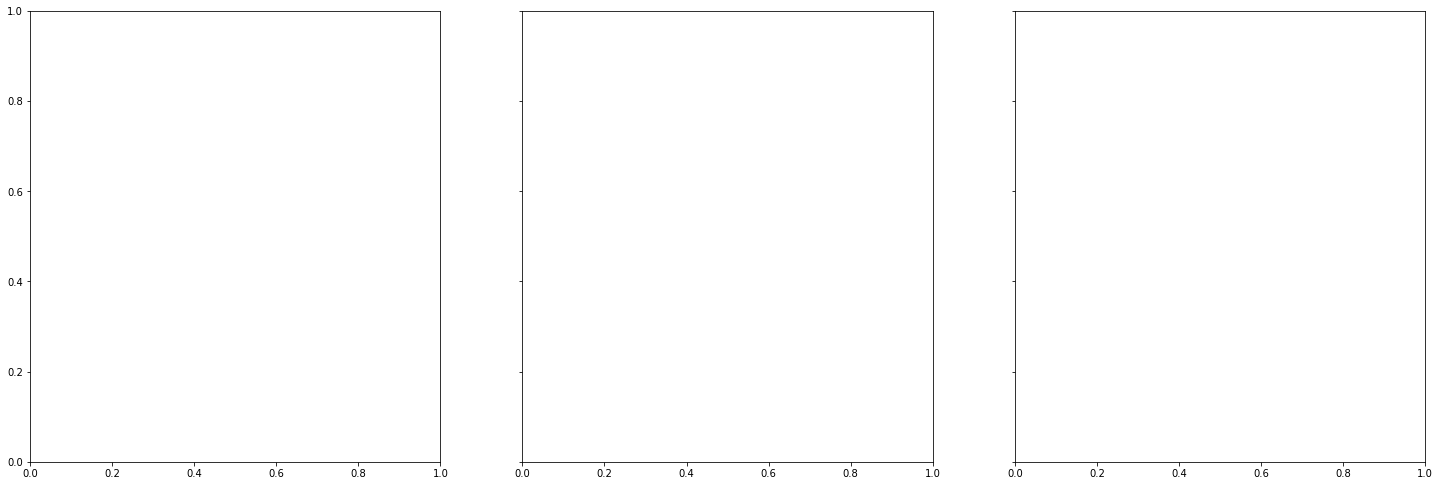

In [8]:
_, axes = plt.subplots(ncols=3, figsize=(25, 8.3), sharex=True, sharey=True, squeeze=True)

ef.compute_derivatives(R0)
c0 = ef.curvature.copy()
ef.compute_derivatives(R1)
c1 = ef.curvature.copy()

mm = np.abs(c0).max()
axes[0].imshow(c0, vmin=-mm, vmax=mm, cmap='seismic')

mm = np.abs(c1).max()
axes[1].imshow(c1, vmin=-mm, vmax=mm, cmap='seismic')

c2 = c0*c1
mm = np.abs(c2.min())
mask = c2 < 0
axes[2].imshow(c2, cmap='plasma', alpha=.5)
axes[2].imshow(np.where(mask, c2, np.nan))

In [9]:
R0 = 60
R1 = R0*1.05

ef.compute_derivatives(R0)
c0 = ef.curvature.copy()

ef.compute_derivatives(R1)
c1 = ef.curvature.copy()

c2 = c0 * c1
eff = ExtremaFinder(c2, loglevel=50)

interp = RegularGridInterpolator([np.arange(s) for s in field.shape], c2, bounds_error=False)
ext = eff.find_extrema(R0*(0.05))
V = interp(ext.pos)

mask_ext = (ext.kind == ndim) & (V < 0)
significance = np.sqrt(np.abs(V / np.nanmin(V)))

mask_ext_sig = mask_ext & (significance > 0.1)

plt.figure(figsize=(15, 15))

# Plot curvature (product of lambdas)
plt.imshow(np.where(mask, c2, np.nan), cmap='plasma')
# and extrema of curvature
plt.plot(ext.pos[mask_ext_sig, 1], ext.pos[mask_ext_sig, 0], 'o')

# Plot field extrema
ext = ef.find_extrema(R0)
for k in range(ndim+1):
    m = ext.kind == k
    plt.plot(ext.pos[m, 1], ext.pos[m, 0], '+')
    
plt.imshow(ef.smooth(R0), alpha=0.5)

NameError: name 'RegularGridInterpolator' is not defined

No handles with labels found to put in legend.


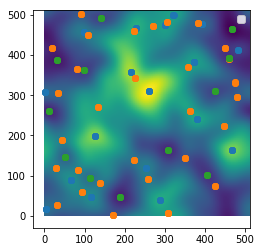

In [8]:
R = 20

pts = ef.find_extrema(R)

plt.imshow(ef.smooth(R), origin='lower')
# plt.plot(ef.smooth(R))
# interp = interp1d(np.arange(0, field.shape[0], 1, dtype=int), ef.smooth(R))
kinds = {0: 'max', 1: 's.p.', 2: 'min'}
for k in range(3):
    mask = pts.kind == k
    # plt.scatter(pts.pos[mask, 0], interp(pts.pos[mask, 0]), label=kinds[k])
    plt.scatter(pts.pos[mask, 1], pts.pos[mask, 0])
    
plt.legend()
# plt.xlim(0, 512)
# plt.ylim(0, 512)

## Detecting slopping saddle

In [12]:
from py_extrema.extrema import ExtremaFinder
from py_extrema.sloping_saddle import SlopingSaddle
import numpy as np

In [13]:
ef = ExtremaFinder(field, nthreads=4, loglevel=30)

In [17]:
Rgrid = np.linspace(1, field.shape[0]/10, 200)
ss = SlopingSaddle(ef, Rgrid)

In [18]:
df = ss.detect_extrema()
df = df.set_index(['iR'])

Finding s. saddle: 100%|██████████| 199/199 [00:00<00:00, 402.02it/s]


In [19]:
for imax in tqdm(np.unique(df.index)):
    plt.figure(figsize=(15, 15))
    _df = df.loc[imax]
    plt.imshow(ef.smooth(Rgrid[imax]).T, cmap='Blues')
    ext0 = ef.find_extrema(Rgrid[imax-1])
    ext1 = ef.find_extrema(Rgrid[imax-0])

    plt.scatter(_df.x, _df.y, marker='o', c='purple', s=200, alpha=0.1, label='Slopping saddle')
    for k, marker in zip(range(len(ef.data_shape)+1), 'x+.d'):
        plt.scatter(*ext0.pos[ext0.kind == k].T, marker=marker, c='yellow', s=100, label=f'k{k}, #0')

    for k, marker in zip(range(len(ef.data_shape)+1), 'x+.d'):
        plt.scatter(*ext1.pos[ext1.kind == k].T, marker=marker, c='red', s=100, label=f'k{k}, #1')

    plt.xlim(0, ef.data_shape[0])
    plt.ylim(0, ef.data_shape[0])
    plt.legend(loc='lower right')
    ! mkdir -p plots
    plt.savefig('plots/ss_and_cp_%s.png' % imax)
    plt.close()

100%|██████████| 167/167 [02:46<00:00,  1.00it/s]


## Play with tree

In [11]:
from scipy.spatial import cKDTree as KDTree

In [12]:
pts = defaultdict(CriticalPoints)
Rlist = np.geomspace(1, 5, 100)
for R in tqdm(Rlist):
    pts[R] = ef.find_extrema(R)

100%|██████████| 100/100 [00:19<00:00,  5.09it/s]


In [13]:
child = {}
data = []
k = 0

skip = 0
for iR, (R1, R2) in enumerate(zip(tqdm(Rlist[:-1]), Rlist[1:])):
    pts1 = pts[R1]
    pts2 = pts[R2]
    
    skip += pts1.npt
    
    for kk in range(ndim+1):
        # Find tree lines
        m1 = pts1.kind == kk
        m2 = pts2.kind == kk

        if m1.sum() == 0 or m2.sum() == 0:
            continue

        N = field.shape[0]
        p1 = np.mod(pts1.pos[m1, :], N)
        p2 = np.mod(pts2.pos[m2, :], N)

        t2 = KDTree(p2, boxsize=field.shape[0])
        d, ind = t2.query(p1, distance_upper_bound=(R2-R1)*4)
        
        indabs = (ind + skip).astype(int)

        j = -1

        for i in range(pts1.npt):
            if not m1[i]:
                continue

            j += 1
            if np.isinf(d[j]): 
                data.append((kk, iR, j, -1,    -1,       pts1.pos[i, 0], pts1.pos[i, 1]))
            else:
                data.append((kk, iR, j,ind[j], indabs[j],pts1.pos[i, 0], pts1.pos[i, 1]))

j = -1        
for i in range(pts2.npt):
    if not m2[i]:
        continue
        
    j += 1
    data.append((pts2.kind[i], iR+1, j, -1, -1, pts2.pos[i, 0], pts2.pos[i, 1]))

100%|██████████| 99/99 [00:09<00:00, 10.45it/s]


In [14]:
stree = pd.DataFrame(data, columns=['kind', 'iR', 'j', 'child', 'child_abs', 'x', 'y']).set_index(['kind', 'iR', 'j'])
stree['iabs'] = range(len(stree))
stree['child_abs'] = stree.child_abs.astype('int')

In [15]:
stree

child  child_abs           x           y     iabs
kind iR j                                                     
0    0  0        0      62624   -0.475694    9.679373        0
        1       -1         -1    0.605134   19.914807        1
        2        2      62626    0.338660   25.730223        2
        3       -1         -1    0.409472   68.092231        3
        4        4      62628    0.684462   76.372336        4
        5        5      62629    0.866292   76.350830        5
        6        7      62631   -0.390006  114.176244        6
        7        8      62632   -0.609962  142.975809        7
        8        9      62633   -0.576614  142.475988        8
        9       10      62634   -0.500077  183.683788        9
        10      11      62635   -0.223988  188.966450       10
        11      12      62636    0.886833  211.833578       11
        12      13      62637   -0.063707  222.792143       12
        13      14      62638    0.996201  239.700385       13
        14      15      62639    0.901210  239.342978       14
        15      16      62640   -0.867752  312.639966       15
        16      17      62641    0.722676  342.331464       16
        17      18      62642    0.186723  381.487272       17
        18      -1         -1    0.608359  381.086431       18
        19      -1         -1   -0.320419  392.452583       19
        20      21      62645   -0.519001  399.857946       20
        21      22      62646   -0.268798  399.598321       21
        22      23      62647   -0.880325  487.591155       22
        23      -1         -1    1.541559   11.549026       23
        24      25      62649    0.465275   19.902626       24
        25      26      62650    0.149316   68.059072       25
        26      27      62651    0.455832   76.583943       26
        27      28      62652    0.471454   76.313871       27
        28      29      62653    1.785298  103.324965       28
        29      31      62655    1.842416  151.176144       29
...            ...        ...         ...         ...      ...
2    99 877     -1         -1  494.950535  204.484203  2271786
        878     -1         -1  495.030616  204.494985  2271787
        879     -1         -1  495.029310  204.487336  2271788
        880     -1         -1  495.945509  330.151464  2271789
        881     -1         -1  495.899140  330.170171  2271790
        882     -1         -1  496.014986  329.971190  2271791
        883     -1         -1  496.005301  330.086149  2271792
        884     -1         -1  497.073043  235.689338  2271793
        885     -1         -1  497.084495  235.694589  2271794
        886     -1         -1  497.045196  235.764475  2271795
        887     -1         -1  497.032092  235.613013  2271796
        888     -1         -1  500.431667  371.590523  2271797
        889     -1         -1  500.413291  371.559643  2271798
        890     -1         -1  500.393894  371.585217  2271799
        891     -1         -1  500.409337  371.567799  2271800
        892     -1         -1  502.971771  394.632666  2271801
        893     -1         -1  503.761918   73.598624  2271802
        894     -1         -1  503.775836   73.427236  2271803
        895     -1         -1  503.003434  394.642295  2271804
        896     -1         -1  503.001759  394.631975  2271805
        897     -1         -1  503.731498   73.502076  2271806
        898     -1         -1  503.722392   73.566822  2271807
        899     -1         -1  510.318229  265.322334  2271808
        900     -1         -1  510.261814  265.440895  2271809
        901     -1         -1  510.923281  344.369585  2271810
        902     -1         -1  510.889396  344.349765  2271811
        903     -1         -1  510.273186  265.415255  2271812
        904     -1         -1  510.271927  265.396155  2271813
        905     -1         -1  510.861090  344.370008  2271814
        906     -1         -1  510.874556  344.341566  2271815

[2271816 rows x 5 columns]

Now plot the tree

In [17]:
def get_line(tree, kind, iR, j):
    '''Compute the line of successors of element at smoothing scale iR and position j'''
    line = [(kind, iR, j)]
    dt = tree.loc[(kind, iR, j), 'child']
    while dt >= 0 and iR < len(Rlist)-2:
        # print(iR, dt)
        line.append((kind, iR, j))
        iR += 1
        j = int(dt)
        dt = int(tree.loc[(kind, iR, j), 'child'])
        
    return line

def get_tip_of_lines(tree, kind, iR):
    '''Find the tip of the ancestor branches from a given kind and iR level.'''
    ancestors = tree.sort_values('iabs').child_abs.as_matrix()
    ilist = tree.loc[(kind, iR, slice(None)), 'iabs'].as_matrix()
    
    return _get_tip_of_line(ancestors, ilist)

def get_tip_of_line(tree, kind, iR, j):
    '''Find the tip (largest ancestor) in a tree.'''
    ancestors = tree.sort_values('iabs').child_abs.as_matrix()
    i0 = np.int(tree.loc[(kind, iR, j), 'iabs'])
    
    i0_ancestor = _get_tip_of_line(ancestors, np.asarray([i0]))
    return i0_ancestor
    
from numba import jit
@jit(nopython=True)
def _get_tip_of_line(ancestor, ilist):
    ancestors = np.zeros(len(ilist), dtype=np.int64)
    for i in range(len(ilist)):
        ia = ancestor[ilist[i]]
        iprev = ia
        while ia >= 0:
            iprev = ia
            ia = ancestor[ia]
        ancestors[i] = iprev
        
    return ancestors

In [18]:
tips = [get_tip_of_lines(stree, k, 0) for k in range(ndim+1)]

/home/ccc/.virtualenvs/astro/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
/home/ccc/.virtualenvs/astro/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/ccc/.virtualenvs/astro/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
/home/ccc/.virtualenvs/astro/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [19]:
m = tips[0] >= 0
stree.set_index('iabs').loc[tips[0][m]]

,child,child_abs,x,y
iabs,,,,
299864,-1,-1,-0.370533,9.918491
1303385,-1,-1,0.839579,25.931298
1395977,-1,-1,0.982649,76.345458
1131577,-1,-1,0.988935,76.492970
2074836,-1,-1,0.521344,116.258173
516985,-1,-1,-0.826666,142.558462
568249,-1,-1,-0.977632,142.320058
410881,-1,-1,-0.575891,183.981607
806670,-1,-1,-0.166522,189.189874


In [20]:
anc = stree.loc[indexes].reset_index()
anc['R'] = Rlist[anc.iR]
anc

NameError: name 'indexes' is not defined

In [21]:
ii = 0

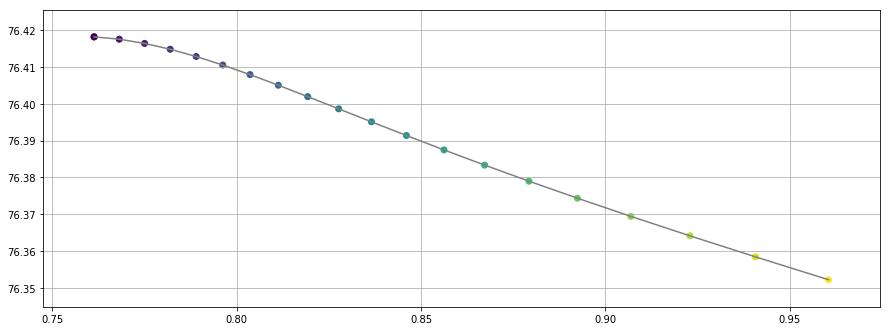

In [35]:
plt.figure(figsize=(15, 15))
ax = plt.gca()

indexes = get_line(stree, 0, ii, 2)
anc = stree.loc[indexes].reset_index()
anc['R'] = Rlist[anc.iR]

xx = anc.x.values
yy = anc.y.values
zz = anc.R.values

cmap = plt.get_cmap('viridis')
colors = cmap(zz)
ax.scatter(xx, yy, c=zz)
ax.plot(xx, yy, 'gray')
ii += 1

ax.set_aspect('equal')
ax.grid(True)

## View in 3D

In [33]:
df_data = []
xyz = 'xyz'
def to_dict(p):
    tmp = {'kind': p.kind}
    for i in range(p.pos.shape[-1]):
        tmp.update({
            xyz[i]: p.pos[:, i],
            f'e{i}': p.eigvals[:, i],
        })
    return tmp
for R, p in pts.items():
    
    tmp = pd.DataFrame(to_dict(p))
    tmp['R'] = R
    df_data.append(tmp)
    
df = pd.concat(df_data).set_index(['kind']).sort_index()

In [42]:
p3.figure(width=800, height=800)

c = ['red', 'green', 'blue', 'cyan']
for i in range(ndim+1):
    _df = df.loc[i, :]
    s = p3.scatter(_df.x, _df.y, np.log10(_df.R), color=c[i], marker='box', size=.25)
# p3.animation_control(s)
p3.show()